# OCR cyrillic

## Imports

In [2]:
# !pip install easyocr
# !pip install natsort
# !pip install wikipedia-api
# !pip install levenshtein

# !pip install "python-doctr[torch,viz,html,contrib]"
# !pip install mplcursors

In [3]:
import gc
import re
import csv
import yaml
import json
import fitz
import shutil
import random
from pathlib import Path
from tqdm.auto import tqdm
import time
import difflib

import wikipediaapi

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import font_manager
from fontTools.ttLib import TTFont

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from PIL import Image, ImageDraw, ImageFont, ImageOps

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import v2
import albumentations as A

from torchmetrics.text import CharErrorRate, WordErrorRate
from torchmetrics.functional.text import char_error_rate, word_error_rate
import Levenshtein

import easyocr

from doctr.io import DocumentFile
from doctr.models import ocr_predictor, recognition
from doctr.models import sar_resnet31
from doctr.datasets import RecognitionDataset
from doctr.transforms import Resize
from doctr.datasets import WordGenerator

In [4]:
class Ansi:
    green = '\033[32m'
    red = '\033[31m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'

In [5]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

PATH_DATASET = Path('dataset')
PATH_DATASET2 = Path('dataset2')
PATH_DATASET_DOCUMETNS = Path('dataset_documents')

In [6]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IS_CUDA = torch.cuda.is_available()
print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


In [7]:
# Список допустимых символов
number = '0123456789'
symbol = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ €₽№°"
lang_char = (
    'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    # 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
)
greek_char = 'αβγΔδεζηΘθιλμνΞξπρΣσ/ςτυφΨψΩω'

CHARACTER = number + symbol + lang_char + greek_char

## Make test dataset

In [116]:
def pdf_to_imges_and_text(pdf_dir, output_dir):
    """
    Функция для нарезания PDF файлов с текстовым слоем на отдельные изображения
    и файл с текстами
    """
    output_dir.mkdir(parents=True, exist_ok=True)

    with open(output_dir.joinpath('labels.csv'), 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.DictWriter(csv_file, fieldnames=['filename', 'words'])
        csv_writer.writeheader() # Записываем заголовки

        # Получаем список всех *.pdf документов
        pdf_paths = pdf_dir.glob('*.pdf')
        
        for pdf_path in pdf_paths:
            pdf_name = pdf_path.name.rstrip('.pdf')
            pdf_document = fitz.open(pdf_path)
            total_pages = pdf_document.page_count
    
            # Обработка каждой страницы
            for page_num in tqdm(range(total_pages), desc=pdf_name):
                page = pdf_document.load_page(page_num)

                # Сохраняем изображение
                pix = page.get_pixmap(dpi=300)
                img_name = f'{pdf_name}_page{page_num + 1:04d}.png'
                img_path = output_dir.joinpath(img_name)
                pix.save(img_path)

                # Сохраняем текстовый слой
                text = page.get_text()
                # Удаляем знаки переносов строк
                text = re.sub(r' \n', '\n', text)
                text = re.sub(r'\xad', '', text)
                text = re.sub(r'[^\S\n]+', ' ', text)
                # text = re.sub(r'[\n\t\r]+', '', text)
                # text = re.sub(r'[\xad]+', '', text)

                csv_writer.writerow({'filename': img_name, 'words': text})

In [117]:
pdf_dir = Path('pdf_for_dataset')
pdf_to_imges_and_text(pdf_dir, PATH_DATASET_DOCUMETNS)

zadachi:   0%|          | 0/21 [00:00<?, ?it/s]

book:   0%|          | 0/108 [00:00<?, ?it/s]

## Make train dataset

Для обучения модели распознавания текста текста с изображений нам понадобится тренировочный и валидационный датасеты.  
Так как задача состоит в распознавании печатного текста, то тренировочные данные можно синтетически сгенерировать. В качестве источников текстовых данных используем API Википедии, откуда спарсим случайные русскоязычные статьи. Далее предобработаем полученный текст и разделим его на небольшие фрагменты, на которых будем обучать модели.

In [11]:
def fetch_wikipedia_articles(
    root_topic: list, 
    language='ru', 
    max_articles=5, 
    search_depth=3
):
    """
    Парсинг случайных статей из Википедии по заданной тематике.
    """
    wiki = wikipediaapi.Wikipedia('Wikipedia-API', language)
    articles = []  # Список текстов статей
    visited_topics = set()  # Для отслеживания уже посещённых тем
    queue_to_visit = set()  # Очередь для обхода связанных тем
    cnt_add_queue = cnt_articles = 0

    # Добавим прогрессбар
    progress_bar = tqdm(total=max_articles, desc='Articles parsing')
    while (queue_to_visit or root_topic) and cnt_articles < max_articles:
        # Сначала обходим названия статей, заданные в root_topic
        # Когда список root_topic, начинаем обход связанных статей в случайном порядке
        if root_topic:
            current_topic = root_topic.pop(0)
        else:
            current_topic = queue_to_visit.pop()

        if current_topic in visited_topics:
            continue

        # Загрузка текущей страницы
        page = wiki.page(current_topic)
        if page.exists():
            # print(f"Загружена статья: {current_topic}")
            # Разбиваем статью по переносу строки и добавляем в список
            articles.extend(page.text.split('\n'))
            visited_topics.add(current_topic)
            cnt_articles += 1

            # Добавление связанных статей в очередь
            if cnt_add_queue <= search_depth:
                links = list(page.links.keys())
                queue_to_visit.update(links)
                cnt_add_queue += 1
                
            progress_bar.update(1)

    visited_topics = list(visited_topics)
    sample_topics = np.random.choice(
        visited_topics, 
        size=min(10, len(visited_topics)), 
        replace=False
    ).tolist()

    print(f'Названия некоторых загруженых статей:', sample_topics)
    print(f'Статей загружено: {Ansi.bold}{cnt_articles}{Ansi.end}')
    return articles

In [12]:
def clean_text(texts, character):
    """
    inplace функция
    Очищает текст, оставляя только слова, состоящие из символов из списка character.
    Удаляет слова, содержащие хотя бы один символ не из списка.
    """
    valid_char_regex = re.compile(f"[{re.escape(character)}]+")
    
    for i in tqdm(range(len(texts)), desc='Text preprocessing'):
        text = texts[i]
        # Удаляем табуляции и переносы строк
        text = re.sub(r'[\n\t\r]+', ' ', text)
        # Удаляем диакритические знаки
        text = re.sub(r'[\u0300-\u036f]+', '', text)
        # Разбиваем текст на слова
        words = text.split() 
        # Оставляем только слова, которые полностью соответствуют списку символов
        valid_words = [word for word in words if valid_char_regex.fullmatch(word)]
        # Перезаписываем очищенную строку
        texts[i] = ' '.join(valid_words)

Важный момент, по умолчанию векторайзеры из sklearn отбрасывают знаки пунктуации, которые должна уметь распознавать модель. Поэтому меняем регулярное выражение в **token_pattern**, что бы сохранить пунктуацию в тексте.

In [13]:
def split_text_with_tfidf(texts, character, max_length=20, ngram_range=(2, 5), token_pattern=r"\S+"):
    """
    Разбивает текст на фразы с использованием CountVectorizer для генерации n-грамм.
    """
    # Предобработка текста
    clean_text(texts, character)

    vectorizer = CountVectorizer(
        ngram_range=ngram_range, 
        analyzer='word', 
        lowercase=False,
        token_pattern=token_pattern,
        stop_words=None
        )
    _ = vectorizer.fit_transform(texts)
    ngrams = vectorizer.get_feature_names_out()

    # Отбираем n-граммы, которые не превышают max_length
    filtered_phrases = [
        ngram for ngram in ngrams if len(ngram) <= max_length
    ]

    return filtered_phrases

In [14]:
# Парсинг статей из Википедии
texts = fetch_wikipedia_articles(['Наука', 'Образование', 'Математика', 'Физика', 'Греческий алфавит'], max_articles=40, search_depth=5)
print('\n')

# Предобработка текста
phrases = split_text_with_tfidf(texts, CHARACTER, max_length=24, ngram_range=(1, 1))
print(f'Сформировано различных фраз: {Ansi.bold}{len(phrases)}{Ansi.end}')

Articles parsing:   0%|          | 0/40 [00:00<?, ?it/s]

Названия некоторых загруженых статей: ['Образование', 'Греческий алфавит', 'Физика', 'Батакское письмо', 'Психолингвистика', 'Унификация', 'Коммутативная диаграмма', 'Семитские языки', 'Школьное образование', 'QtiPlot']
Статей загружено: 40




Text preprocessing:   0%|          | 0/8459 [00:00<?, ?it/s]

Сформировано различных фраз: 24405


In [15]:
print(f'{Ansi.bold}Несколько случайных фраз:{Ansi.end}')
random.choices(phrases, k=15)

Несколько случайных фраз:


['отношений',
 '(раздел',
 'бет',
 'Условная',
 'проведены',
 'позволяющих',
 'тензорами.',
 'Большое',
 'змеёй,',
 '(фоносемантического),',
 'Томаса',
 'лингвистика.',
 '(словарей',
 'Сама',
 'патопсихолингвистики']

In [146]:
# texts_book = pd.read_csv('dataset_documents/labels.csv')['words'].tolist()
# phrases2 = split_text_with_tfidf(texts_book, CHARACTER, max_length=24, ngram_range=(1, 1))
# print(f'Сформировано различных фраз: {Ansi.bold}{len(phrases)}{Ansi.end}')

In [16]:
# phrases2 = split_text_with_tfidf(texts, CHARACTER, max_length=27, ngram_range=(1, 1), token_pattern=r"(?u)\b\w\w+\b")
# print(f'Сформировано различных фраз: {Ansi.bold}{len(phrases2)}{Ansi.end}')

Текстовая информация получена. Далее на ее основе сгенерируем изображения и составим датасет, где каждой картинке будет соответствовать определенный текст

In [17]:
def _is_supported_chars(font_path, unicode_list):
    """
    Проверяет, поддерживает ли шрифт все нужные символы
    """
    try:
        font = TTFont(font_path)
        cmap = font['cmap'].getBestCmap()
        for code in unicode_list:
            if code not in cmap:
                return False
        return True
    except:
        return False

def get_valid_fonts(unicode_list):
    """
    Возвращает список шрифтов, поддерживающих кириллицу.
    """
    # Получаем список всех шрифтов, установленных в системе
    fonts = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')  # Системные шрифты
    return [font for font in fonts if _is_supported_chars(font, unicode_list)]

In [18]:
def generate_dataset(output_dir, fonts, num_images, text_samples, random_words=None):
    """
    Генерирует синтетический датасет.
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    annotations = {}
    i = 0
    
    # for i in tqdm(range(num_images), desc=f'Images generation "{PATH_DATASET.joinpath('train').name}"'):
    progress_bar = tqdm(total=num_images, desc=f'Images generation "{output_dir.name}"')
    while i < num_images:
        # Случайный текст и шрифт
        text = random.choice(text_samples)
        
        if random_words is not None and random.random() < .1:
            text = random.choice(random_words)

        font_path = random.choice(fonts)
        font_size = 30
        font = ImageFont.truetype(font_path, font_size)

        # print(text, font_path)

        # Вычисление размеров текста
        bbox = font.getbbox(text)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        # Создание пустого изображения
        background_color = (random.randint(245, 255), random.randint(245, 255), random.randint(245, 255))
        img = Image.new('RGB', (text_width, text_height), color=background_color)
        draw = ImageDraw.Draw(img)

        # Отрисовка текста
        text_color = (random.randint(0, 10), random.randint(0, 10), random.randint(0, 20))
        draw.text((0, -bbox[1]), text, fill=text_color, font=font)

        # Сохранение изображения
        img_name = f"text_{i:05d}.png"
        img_path = output_dir.joinpath(img_name)
        try:
            img.save(img_path)
    
            # Добавление записи в аннотации
            annotations[img_name] = text
    
            i += 1
            progress_bar.update(1)
        except:
            print(text, font_path)

    # Сохранение аннотаций в json
    annotations_file = output_dir.joinpath('labels.json')
    with open(annotations_file, 'w', encoding='utf-8') as file:
        json.dump(annotations, file, indent=2, ensure_ascii=False)

Получим список системных шрифтов, поддерживающих все символы, которые нам необходимо уметь распознавать. 
При генерации каждого отдельного изображения будем случайно выбирать один из доступных шрифтов. Так же для разнообразия данных будут применяться различные случайные аугментации (шум, искажения, изменение яркости и т.д), изменение размера текста и и вариации оттенков шрифта и фона.

In [19]:
# Получим список кодов unicode для всех заранее определенных символов, 
unicode_character = list(map(ord, CHARACTER))

system_fonts = get_valid_fonts(unicode_character)
print(f"Найдено подходящих шрифтов: {Ansi.bold}{len(system_fonts)}{Ansi.end}")

Найдено подходящих шрифтов: 48


Отберем интересующие нас шрифты

In [20]:
# pattern = r'NotoSerif|DejaVu|NotoSans'
# select_font = lambda x: re.search(pattern, x)

# good_fonts = [font for font in system_fonts if select_font(font)]
# len(good_fonts)

good_fonts = system_fonts

In [21]:
# txt = 'съешь еще этих мягких французских булок'

# for font_path in good_fonts:
#     font = ImageFont.truetype(font_path, size=30)
#     bbox = font.getbbox(txt)
#     text_width = bbox[2] - bbox[0]
#     text_height = bbox[3] - bbox[1]
    
#     img = Image.new('L', (text_width, text_height), color=255)
#     draw = ImageDraw.Draw(img)
#     draw.text((0, -bbox[1]), txt, font=font)

#     print(font_path)
#     plt.imshow(img, cmap='gray')
#     plt.show()

Дополнительно генерируем небольшие комбинации из символов, которые нам нужно уметь распознавать, но которые не так часто встречаются в текстах Википедии.

In [22]:
# wg = WordGenerator(vocab=symbol + greek_char, min_chars=1, max_chars=3, font_family=good_fonts[0], num_samples=100000)

# random_words = []
# for i in tqdm(range(100000)):
#     random_words.append(wg[0][1])

# random_words = [word for word in random_words if word != ' ']

Определяем размеры датасетов и генерируем изображения.

In [147]:
train_size = 100000
val_size = 10000
test_size = 10000

generate_dataset(PATH_DATASET.joinpath('train'), good_fonts, train_size, phrases)
generate_dataset(PATH_DATASET.joinpath('val'), good_fonts, val_size, phrases)
generate_dataset(PATH_DATASET.joinpath('test'), good_fonts, test_size, phrases)

Images generation "train":   0%|          | 0/100000 [00:00<?, ?it/s]

Images generation "val":   0%|          | 0/10000 [00:00<?, ?it/s]

Images generation "test":   0%|          | 0/10000 [00:00<?, ?it/s]

In [24]:
# train_size = 50000
# val_size = 10000
# test_size = 10000

# generate_dataset(PATH_DATASET2.joinpath('train'), good_fonts, train_size, phrases2)
# generate_dataset(PATH_DATASET2.joinpath('val'), good_fonts, val_size, phrases2)
# generate_dataset(PATH_DATASET2.joinpath('test'), good_fonts, test_size, phrases2)

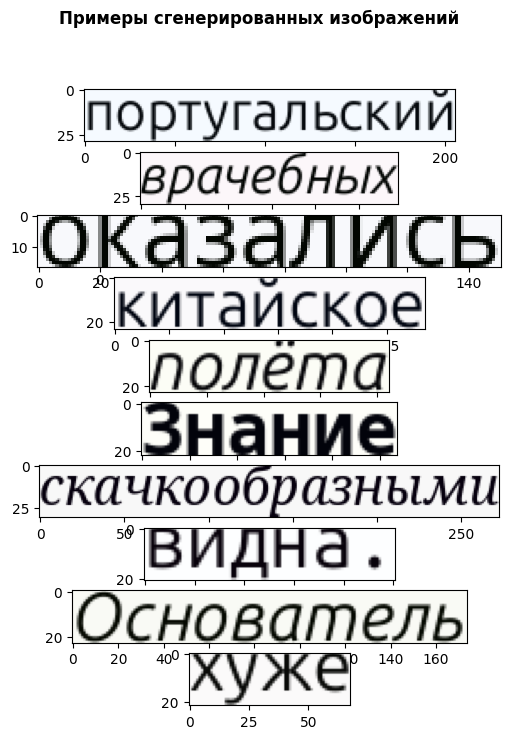

In [148]:
random_img = random.choices(list(PATH_DATASET.joinpath('train').rglob('*.png')), k=10)

fig, axes = plt.subplots(len(random_img), figsize=(8, 8))
fig.suptitle('Примеры сгенерированных изображений', fontweight='bold')
for ax, path_img in zip(axes.flat, random_img):
    img = Image.open(path_img)
    ax.imshow(img)
    # ax.axis('off')
plt.show()

## Preparing torch dataset

In [26]:
# Случайные аугментации
transform_albumentations = A.Compose([
    # Добавление Gaussian шума
    A.GaussNoise(var_limit=(100, 600), p=.4),

    # # Добавление артефактов
    # A.CoarseDropout(
    #     num_holes_range=(3, 7), 
    #     hole_height_range=(5, 9), 
    #     hole_width_range=(5, 9), 
    #     fill_value=(255, 255, 255), 
    #     p=.3
    # ),
        
    # Размытие
    A.GaussianBlur(blur_limit=(1, 3), p=.3),
    
    # Искажения геометрии
    A.Perspective(scale=(.002, .004), p=.3),
    
    # Изменение яркости и контраста
    A.RandomBrightnessContrast(
        brightness_limit=(-.2, .2), 
        contrast_limit=(-.2, .2), 
        p=.6
    ),
    
    # Эффект тени
    A.RandomShadow(
        shadow_roi=(0, 0, 1, 1),
        num_shadows_lower=1, 
        num_shadows_upper=4, 
        shadow_intensity_range=(.9, .95), 
        p=.3
    ),
    
    # Эффект засвета
    A.RandomSunFlare(
        flare_roi=(0, 0, 1, 1), 
        angle_range=(.1, 1), 
        src_radius=60, 
        p=.2
    ),
    
    # Эффект искажения линий
    A.ElasticTransform(alpha=3, sigma=50, p=.25),
    ])

In [27]:
class CustomDataset(Dataset):
    
    def __init__(self, path, transform=None, transform_alb=None):
        self.path = path

        with open(path.joinpath('labels.json'), 'r', encoding="utf-8") as file:
            labels = json.load(file)
    
        for img_name, label in labels.items():
            if not Path('dataset/train', img_name).exists():
                raise FileNotFoundError(f"unable to locate {Path('dataset/train', img_name)}")

        self.labels = list(labels.items())
        self.transform = transform
        self.transform_alb = transform_alb

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name, target = self.labels[idx]
        img = Image.open(self.path.joinpath(img_name)).convert('RGB')

        if self.transform_alb is not None:
            img = np.array(img)
            img = self.transform_alb(image=img)['image']

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [68]:
transform = v2.Compose([
    v2.ToImage(),
    v2.RandomRotation(degrees=1.5, expand=True),
    Resize((32, 128), preserve_aspect_ratio=True, symmetric_pad=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))
])

train_set = CustomDataset(PATH_DATASET.joinpath('train'), transform=transform, transform_alb=transform_albumentations)
val_set = CustomDataset(PATH_DATASET.joinpath('val'), transform=transform, transform_alb=transform_albumentations)
test_set = CustomDataset(PATH_DATASET.joinpath('test'), transform=transform, transform_alb=transform_albumentations)

In [69]:
# train_set2 = CustomDataset(PATH_DATASET2.joinpath('train'), transform=transform, transform_alb=transform_albumentations)
# val_set2 = CustomDataset(PATH_DATASET2.joinpath('val'), transform=transform, transform_alb=transform_albumentations)
# test_set2 = CustomDataset(PATH_DATASET2.joinpath('test'), transform=transform, transform_alb=transform_albumentations)

In [70]:
class DeNormalize(v2.Normalize):
    """
    Функция для денормализации изображений
    """
    def __init__(self,mean, std, *args, **kwargs):
        new_mean = [-m/s for m, s in zip(mean, std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

denorm = DeNormalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))

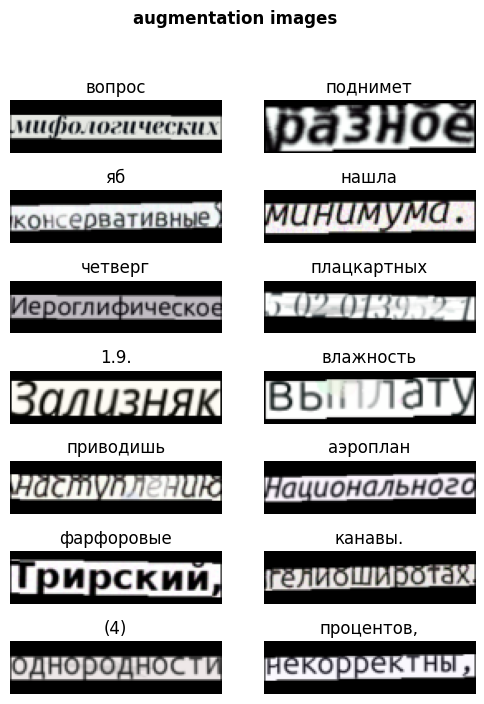

In [149]:
def show_images_dataset(dataset, num=14):
    length = len(dataset)
    indices = np.random.choice(length, min(num, length))

    fig, axes = plt.subplots(num // 2, 2, figsize=(6, 8))
    fig.suptitle('augmentation images', fontweight='bold')
    for ax, idx in zip(axes.flat, indices):
        img, target = dataset[idx]
        img = (denorm(img) * 255).to(torch.uint8)
        img = img.numpy().transpose(1, 2, 0)
        ax.set_title(target)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


show_images_dataset(train_set)

In [74]:
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# train_loader2 = DataLoader(train_set2, batch_size=BATCH_SIZE, shuffle=True)
# val_loader2 = DataLoader(val_set2, batch_size=BATCH_SIZE, shuffle=False)
# test_loader2 = DataLoader(test_set2, batch_size=BATCH_SIZE, shuffle=False)

## docTR train

In [34]:
path_save_model = Path('models_doctr')
path_save_model.mkdir(parents=True, exist_ok=True)

In [46]:
def save_model(path, model, optimizer, scheduler, epoch):
    checkpoint = {
        'info': {
            'datetime': time.ctime(),
        },
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
    }

    torch.save(checkpoint, path.joinpath(f'best_epoch_{epoch+1}.pth'))

In [562]:
load_state = torch.load('best_epoch_7.pth', map_location=DEVICE)

/tmp/ipykernel_32312/2551193873.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_state = torch.load('best_epoch_7.pth', map_location=DEVICE)


In [75]:
model = sar_resnet31(pretrained=True, vocab=CHARACTER).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.8)
best_cer = .01

In [564]:
model.load_state_dict(load_state['model'])
# optimizer.load_state_dict(load_state['optimizer'])
# scheduler.load_state_dict(load_state['scheduler'])

<All keys matched successfully>

In [36]:
metric_cer = CharErrorRate()
metric_wer = WordErrorRate()

In [76]:
gc.collect()
torch.cuda.empty_cache()

EPOCHS = 3

for epoch in range(EPOCHS):
    train_loss = []
    last_lr = scheduler.get_last_lr()[0]

    # TRAIN
    model.train()
    loop = tqdm(train_loader, leave=False)
    for images, labels in loop:
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images, labels)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().item())
        loop_description = f'Epoch [{epoch + 1}/{EPOCHS}], lr: {last_lr:.1e}, loss: {np.mean(train_loss):.4f}'
        loop.set_description(loop_description)

    # VALID
    metric_cer.reset()
    metric_wer.reset()
    model.eval()
    with torch.no_grad():
        loop = tqdm(val_loader, desc='evaluation', leave=False)
        for images, labels in loop:
            images = images.to(DEVICE)
            outputs = model(images)
            preds = [out[0] for out in outputs['preds']]
    
            metric_cer.update(preds, labels)
            metric_wer.update(preds, labels)

    # Вычисление итоговой метрики
    val_cer = metric_cer.compute().item()
    val_wer = metric_wer.compute().item()

    # Вывод результатов обучения для эпохи
    print(
        loop_description, 
        f"| CER: {Ansi.bold}{val_cer:.4f}{Ansi.end},",
        f"WER: {Ansi.bold}{val_wer:.4f}{Ansi.end}",
        end = ' '
    )

    # Scheduler step
    scheduler.step()
    
    # Save best model
    if best_cer > val_cer:
        best_cer = val_cer
        save_model(path_save_model, model, optimizer, scheduler, epoch)
        print(f'{Ansi.bold}{Ansi.green}save model{Ansi.end}')

    # Save last model
    torch.save(model.state_dict(), path_save_model.joinpath('last.pth'))

  0%|          | 0/1563 [00:00<?, ?it/s]

evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/3], lr: 2.0e-04, loss: 0.0110 | CER: 0.0027, WER: 0.0138 save model


  0%|          | 0/1563 [00:00<?, ?it/s]

evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/3], lr: 1.6e-04, loss: 0.0069 | CER: 0.0016, WER: 0.0082 save model


  0%|          | 0/1563 [00:00<?, ?it/s]

evaluation:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/3], lr: 1.3e-04, loss: 0.0048 | CER: 0.0020, WER: 0.0096 

## Test model

In [140]:
def calculation_score_doctr(model, path_dataset):
    """
    Расчет Levenshtein distance и Levenshtein ratio
    """
    labels = path_dataset.joinpath('labels.csv')
    labels_csv = pd.read_csv(path_dataset.joinpath('labels.csv'), index_col=0)
    
    ed_list, ed_norm_list = [], []
    cer_list, wer_list = [], []
    len_target, len_output = [], []
    
    for img_name in tqdm(labels_csv.index):
        gt_text = labels_csv.loc[img_name, 'words']
        gt_text = re.sub(r'\xad', '', gt_text)

        img_path = path_dataset.joinpath(img_name)
        img_doc = DocumentFile.from_images(img_path)

        output = model(img_doc)
        pred_text = output.render()
        
        ed = Levenshtein.distance(gt_text, pred_text)
        ed_norm = 1 - (ed / (len(gt_text) + len(pred_text)))
        cer = char_error_rate(pred_text, gt_text)
        wer = word_error_rate(pred_text, gt_text)

        len_target.append(len(gt_text))
        len_output.append(len(pred_text))
        
        ed_list.append(ed)
        ed_norm_list.append(ed_norm)
        cer_list.append(cer)
        wer_list.append(wer)

    print(
        f'len GT:   {np.mean(len_target):.2f}\n'
        f'len pred: {np.mean(len_output):.2f}\n\n'
        f'ED:       {Ansi.bold}{np.mean(ed_list):.4f}{Ansi.end}\n'
        f'ED_norm:  {Ansi.bold}{np.mean(ed_norm_list):.4f}{Ansi.end}\n\n'
        f'CER:      {Ansi.bold}{np.mean(cer_list):.4f}{Ansi.end}\n'
        f'WER:      {Ansi.bold}{np.mean(wer_list):.4f}{Ansi.end}'
    )

In [42]:
def highlight_diff(gt, pred):
    """
    Функция для выделения ошибок в предсказанном тексте
    """
    mather = difflib.SequenceMatcher(None, gt, pred)
    result = []
    for tag, i1, i2, j1, j2 in mather.get_opcodes():
        part_txt = pred[j1:j2]
        
        match tag:
            case 'equal':
                result.append(part_txt)
            case 'replace' | 'insert':
                if part_txt == ' ':
                    result.append(f'{Ansi.red}[SPACE]{Ansi.end}')
                else:
                    result.append(f'{Ansi.red}{part_txt}{Ansi.end}')
            case 'delete':
                result.append(f'{Ansi.red}{Ansi.bold}[DEL]{Ansi.end}')
                
    return ''.join(result)

In [125]:
def get_predict_doctr(model, path_dataset, img_name, image_size=7):
    """
    Отрисовка bboxes и получение предсказания для одного изображения
    """

    gc.collect()
    torch.cuda.empty_cache()

    img_path = path_dataset.joinpath(img_name)
    img_doc = DocumentFile.from_images(img_path)
    img = Image.open(img_path).convert('RGB')
    labels_csv = pd.read_csv(path_dataset.joinpath('labels.csv'), index_col=0)
   
    gt_text = labels_csv.loc[img_name, 'words']
    gt_text = re.sub(r'\xad', '', gt_text)

    output = model(img_doc)
    pred_text = output.render()

    plt.figure(figsize=(image_size, image_size))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # gt_text = gt_text.lower().replace('ё', 'е')
    # pred_text = pred_text.lower().replace('ё', 'е')

    # Выделение ошибок предсказания
    pred_text_highlight = highlight_diff(gt_text, pred_text)

    # Расчет метрик
    edit_dist = Levenshtein.distance(gt_text, pred_text)
    edit_dist_norm = 1 - (edit_dist / (len(gt_text) + len(pred_text)))
    cer = char_error_rate(pred_text, gt_text)
    wer = word_error_rate(pred_text, gt_text)
    
    print(
        f'ED:      {Ansi.bold}{edit_dist}{Ansi.end}\n'
        f'ED_norm: {Ansi.bold}{edit_dist_norm:.4f}{Ansi.end}\n\n'
        f'CER:     {Ansi.bold}{cer:.4f}{Ansi.end}\n'
        f'WER:     {Ansi.bold}{wer:.4f}{Ansi.end}\n\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Prediction{Ansi.end} {Ansi.bold}(s:{len(pred_text)}, w:{len(pred_text.split())}){Ansi.end}\n'
        f'{pred_text_highlight}\n'
        f'{"-" * 80}\n'
        f'{Ansi.bold}{Ansi.underline}Ground Truth{Ansi.end} {Ansi.bold}(s:{len(gt_text)}, w:{len(gt_text.split())}){Ansi.end}\n'
        f'{gt_text}\n'
        f'{"-" * 80}\n'
    )

Подгрузим предобученную модель

In [155]:
load_state = torch.load('models_doctr/best_epoch_2.pth', map_location=DEVICE, weights_only=True)

model = sar_resnet31(vocab=CHARACTER).to(DEVICE)
model.load_state_dict(load_state['model'])

<All keys matched successfully>

In [156]:
model_predict = ocr_predictor(pretrained=True, reco_arch=model).to(DEVICE)

Точность на тестовом датасете

In [177]:
calculation_score_doctr(model_predict, PATH_DATASET_DOCUMETNS)

  0%|          | 0/124 [00:00<?, ?it/s]

len GT:   1603.84
len pred: 1643.52

ED:       84.0484
ED_norm:  0.9731

CER:      0.0545
WER:      0.2184


Несколько примеров работы модели. Красным цветом отмечены ошибки. На длинных текстах может отобразиться (выделиться красным цветом) больше ошибок, чем есть на самом деле, это особенность работы библиотеки difflib.

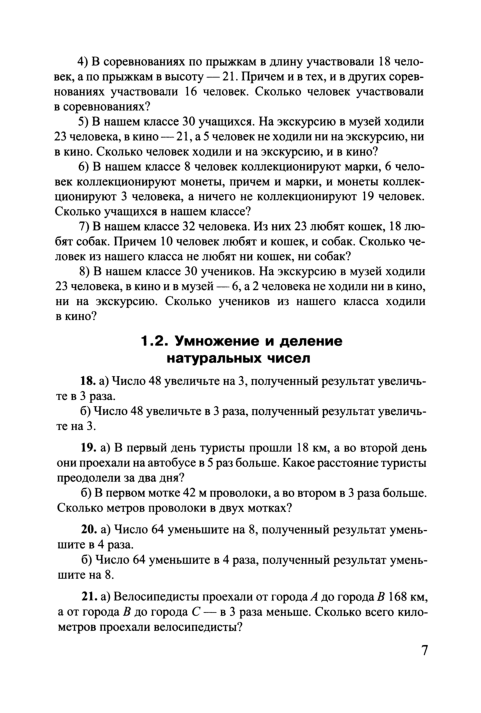

ED:      67
ED_norm: 0.9805

CER:     0.0392
WER:     0.1577

--------------------------------------------------------------------------------
Prediction (s:1728, w:313)
4) В соревнования[DEL] по прыжкам В длину участвовали 18 чело-
век, а по прыжкам В высоту
21.. Причем и в тех, и В других сорев-
нованиях участвовали 16 человек. Сколько человек участвовали
В соревнованиях?
5) В нашем классе 30 учащихся. На экскурсию в музей. ходили
23 человека, В кино- 21,а: 5 человек не ходили ни на экскурсию, ни
В кино. Сколько человек ходили и на экскурсию, и В кино?
6) В нашем классе 8 человек поллекционирую[DEL] марки, 6 чело-
век коллекционирую[DEL] монеты, причем и марки, и монеты коллек-
ционируют 3 человека, а ничего не полленцирирурую[DEL] 19 человек.
Сколько учащихся в нашем классе?
7) В нашем классе 32. человека. Из них 23 любят кошек, 18 лю-
бят. собак. Причем 10 человек любят и кошек, и собак. Сколько че-
ловек из нашего класса не любят ни кошек, ни собак?
8) В нашем классе 30 учеников. 

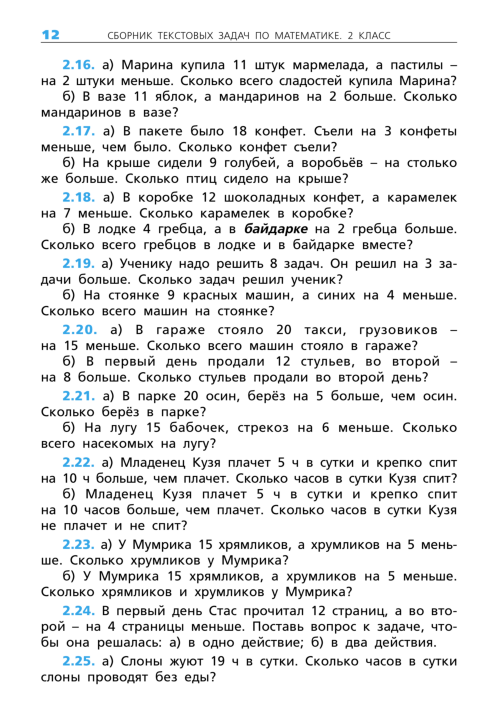

ED:      55
ED_norm: 0.9851

CER:     0.0299
WER:     0.1243

--------------------------------------------------------------------------------
Prediction (s:1841, w:343)
12
СБОРНИК ТЕКСТОВЫХ ЗАДАЧЧ по мАТЕМАТИКЕ. 2 КЛАСС
[DEL]2.16.. а) Марина купила 11 штук мармелада, а пастилы
на 2 штуки меньше. Сколько ВСего сладостеи купила Иарина?
б) В вазе 11 яблок, а мандаринов на 2 больше. Сколько
мандаринов В вазе?
2.17. а) В пакете было 18 конфет. Съели на 3 конфеты
меньше, чем было. Сколько конфет съели?
б) На крыше сидели 9 голубей, а воробьёв = на столько
же больше. Сколько птиц, сидело на крыше?
2.18.. а) В коробке 12 шоколадных конфет, а карамелек
на 7 меньше. Сколько карамелек в коробке?
б) В лодке 4 гребца, а В баидарке на 2 гребца больше.
Сколько всего гребцов В лодке И В байдарке [DEL]вместе?
2.19. а) Ученику надо решить 8 задач. Он решил на 3 3а-
дачи больше. Сколько задач решил ученик?
б) На стоянке 9 красных машин, а синих на 4 меньше.
Сколько всего машин на стоянке?
2.20. а) В гар

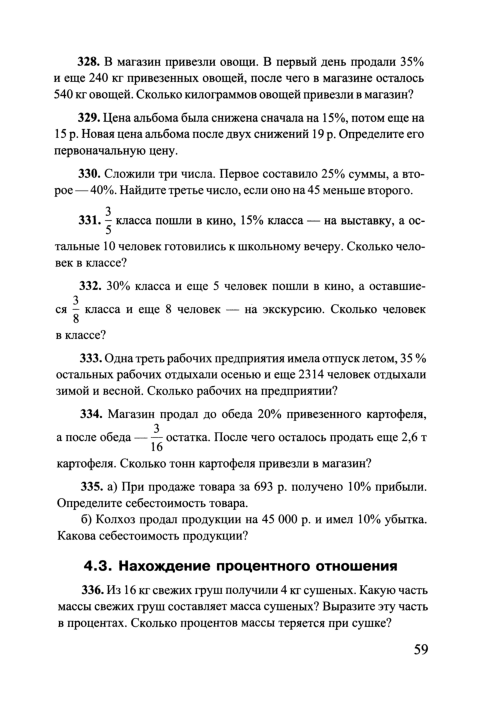

ED:      67
ED_norm: 0.9775

CER:     0.0454
WER:     0.2097

--------------------------------------------------------------------------------
Prediction (s:1509, w:245)
3288. В магазин привезли овощи. В первый день продали 35%.
и еще 240 кг привезенных овощей, после чего в магазине осталось
5400: кг овощей. Сколько килограммов овощей. привезли в магазин?
3299. Цена альбома была снижена сначала на 15%,, потом. еще на
15у р. Новая цена альбома после двух снижений 19 р. Определите его
перно-тальную цену.
330.. Сложили трии числа. Первое составило 25%. суммы, а вто-
рое-- 40%. Найдите третье число, если оно на 45 меньше второго.
3
3311. - класса пошли в кино, 15%. класса
на выставку, а Ос-
5
тальные 10 человек готовились к школьному вечеру. Сколько чело-
век. в классе?
3322. 30%. класса и еще 5 человек пошли В кино, а оставшие-
3
ся - класса и еще 8 человек
на экскурсию. Сколько человек
8
в классе?
333.[DEL]Одна треть; рабочих предприятия имела отпуск летом, 35 %
остальных рабочих отдыхал

In [171]:
labels = pd.read_csv('dataset_documents/labels.csv', index_col=0).index
random_images = np.random.choice(labels, 3)

# get_predict_doctr(model_predict, PATH_DATASET_DOCUMETNS, 'book_page0019.png', image_size=12)
# get_predict_doctr(model_predict, PATH_DATASET_DOCUMETNS, 'zadachi_page0002.png', image_size=12)
for img_name in random_images:
    get_predict_doctr(model_predict, PATH_DATASET_DOCUMETNS, img_name, image_size=9)